# Polarization and Focus diverse phase retrieval for Full Jones Matrix sensing

This is inspired by Gutierrez-Cuevas et al. 2023 (incl. Luis, Miguel Alonso) where you use AD to fit to a bunch of PSFs that include diversity in retardance and defocus. The experimental setup is something like this

```
[Source] ---> [Rotating Retarder] ---> [Optical System to Sense] ---> [Analyzer] ---> [Focus Stage]
```

Where the retarder and focus stage are adjusted to get the polarization and focus diversity. In minimally polarizing systems, an analyzer is necessary to actually see the change that the retarder applies. Using a Wollaston is better because you get twice as much data.

## Building the Jones Matrix

In [34]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable

# The prysm stuff
from prysm.coordinates import make_xy_grid, cart_to_polar
from prysm.propagation import Wavefront, focus_fixed_sampling
from prysm.geometry import circle,spider
from prysm.segmented import CompositeHexagonalAperture
from prysm import thinlens
from prysm.polynomials import (
    noll_to_nm,
    zernike_nm,
    zernike_nm_sequence,
    hopkins,
    sum_of_2d_modes
)

np.random.seed(8242024)

In [35]:
# USER INPUT HERE
# IC = Instrument Configuration
IC = {
    'image_dx' : 2, # um
    'pupil_diameter' : 25.4, # mm
    'focal_length' : 254, # mm
    'wavelength' : 0.94, # um
}
Npolynomials = 5

In [36]:
# optical system parameters
epd = IC['pupil_diameter'] # mm
efl = IC['focal_length'] # mm, Keck is F/13 I think
fno = efl / epd
wvl = IC['wavelength'] # um
img_dx = IC['image_dx']
img_npix = 64

real_coeffs = np.random.random([Npolynomials, 2, 2])
imag_coeffs = np.random.random([Npolynomials, 2, 2])
coeffs = real_coeffs + 1j* imag_coeffs

# build the coordinate grids
x, y = make_xy_grid(128, diameter=epd)
r, t = cart_to_polar(x, y)
dx_p = x[0,1] - x[0,0]

A = circle(epd / 2, r)

# construct a polynomial basis to generate wavefront error
r_z = r / (epd / 2) # normalized radius
nms = [noll_to_nm(j) for j in range(Npolynomials)]
basis = np.array(list(zernike_nm_sequence(nms, r_z, t, norm=True))).astype(np.complex128)
masked_basis = [A * b for b in basis]
jones = sum_of_2d_modes(masked_basis, coeffs) * 1e-2

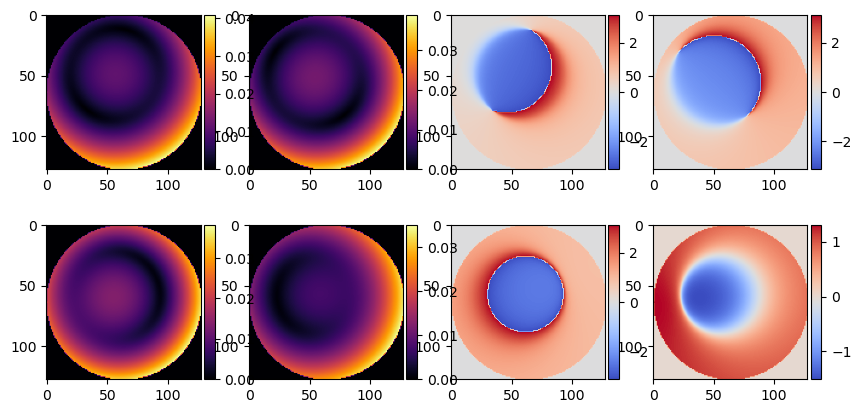

In [37]:
def plot_jones(J, kind='polar'):

    if kind == 'polar':
        op1 = np.abs
        op2 = np.angle
        cm1 = 'inferno'
        cm2 = 'coolwarm'
    else:
        op1 = np.real
        op2 = np.imag
        cm1 = 'viridis'
        cm2 = 'plasma'

    fig, ax = plt.subplots(ncols=4, nrows=2, figsize=[10,5])
    for i in range(2):
        for j in range (2):
            im = ax[i, j].imshow(op1(J[..., i, j]), cmap=cm1)
            div = make_axes_locatable(ax[i, j])
            cax = div.append_axes("right", size="7%", pad="2%")
            cb = fig.colorbar(im, cax=cax)

    for i in range(2):
        for j in range(2):
            im = ax[i, j+2].imshow(op2(J[..., i, j]), cmap=cm2)
            div = make_axes_locatable(ax[i, j+2])
            cax = div.append_axes("right", size="7%", pad="2%")
            cb = fig.colorbar(im, cax=cax)

    plt.show()

plot_jones(jones)

In [38]:
from prysm.x.polarization import quarter_wave_plate, linear_polarizer, add_jones_propagation
add_jones_propagation()
from prysm.propagation import focus_fixed_sampling, focus_fixed_sampling_backprop

In [39]:
# Create a PSF
psfpol = focus_fixed_sampling(
        jones,
        input_dx=dx_p,
        prop_dist = efl,
        wavelength=wvl,
        output_dx=img_dx,
        output_samples=img_npix,
        shift=(0, 0),
        method='mdft')

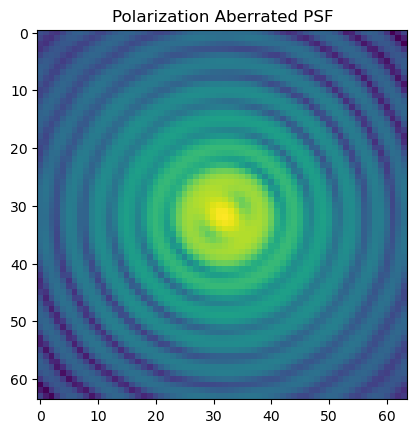

In [40]:
D = np.sum(np.abs(psfpol)**2, axis=(-2,-1))
plt.title('Polarization Aberrated PSF')
plt.imshow(np.log10(D))

In [61]:
# Stuff before the forward model
# configure the defocus polynomial
defocus = 1 # wave
x, y = make_xy_grid(A.shape[0], diameter=epd)
r, t = cart_to_polar(x, y)
r_z = r / (epd / 2)
defocus_polynomial = hopkins(0, 2, 0, r_z, t, 0)
defocus_aberration = 2 * np.pi * defocus_polynomial * defocus * A

# polarization optics
P = linear_polarizer(theta=0, shape=[img_npix, img_npix])
R = quarter_wave_plate(theta=0, shape=A.shape)

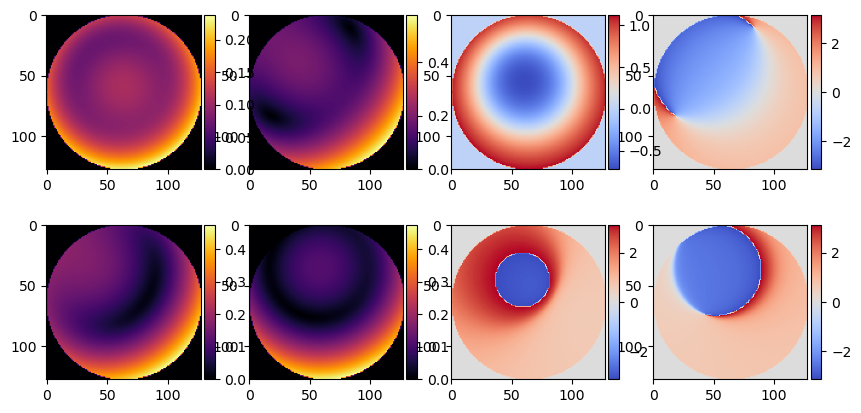

In [87]:
plot_jones(j)

# The Forward Model

In [90]:
x0 = np.random.random([Npolynomials, 2, 2, 2]) / 10
x0 = x0.ravel()

# ---- input
x0 = x0.reshape([Npolynomials, 2, 2, 2])
a = x0[..., 0] + 1j*x0[..., 1] # 

# basis expansion
j = sum_of_2d_modes(masked_basis, a)

# apply focus diversity
W = np.exp(1j * defocus_aberration)
J = j * W[..., np.newaxis, np.newaxis]

# apply polarization diversity
g = J @ R

# to image plane
G = focus_fixed_sampling(
        g,
        input_dx=dx_p,
        prop_dist = efl,
        wavelength=wvl,
        output_dx=img_dx,
        output_samples=img_npix,
        shift=(0, 0),
        method='mdft')

# Analyze polarization diversity
H = G @ P

Hxx = H[..., 0, 0]
Hxy = H[..., 0, 1]
Hyx = H[..., 1, 0]
Hyy = H[..., 1, 1]

# compute intensity
I = np.abs(Hxx)**2 + np.abs(Hxy)**2 + np.abs(Hyx)**2 + np.abs(Hyy)**2

# compute error
E = np.sum(I-D)**2


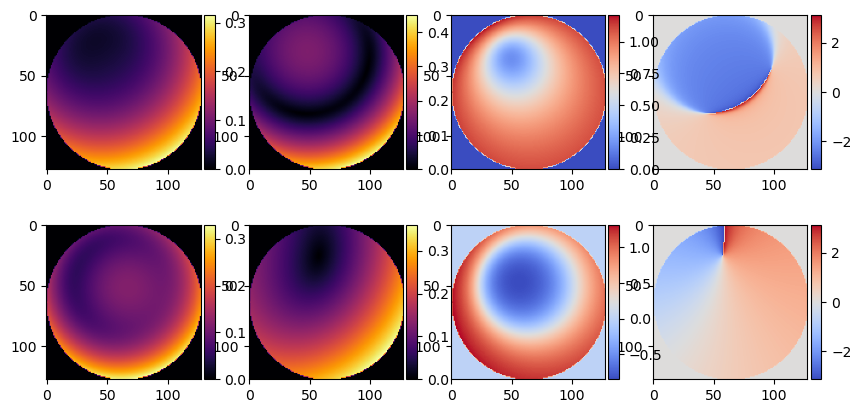

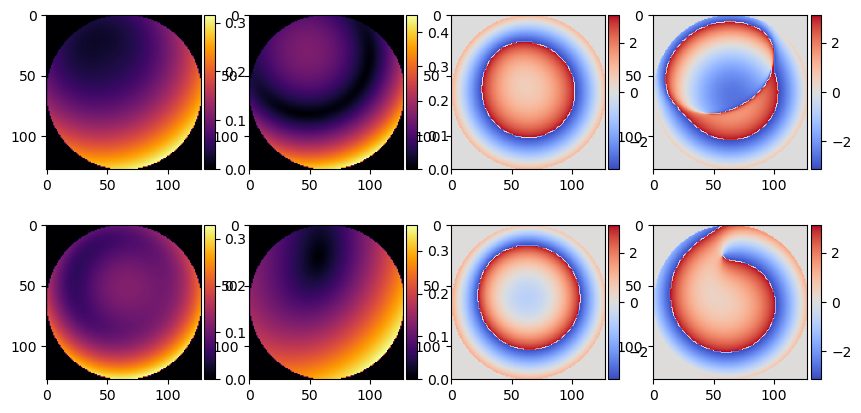

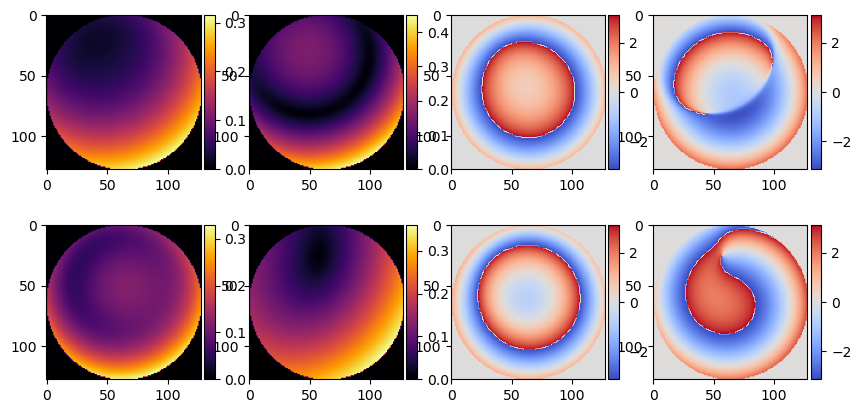

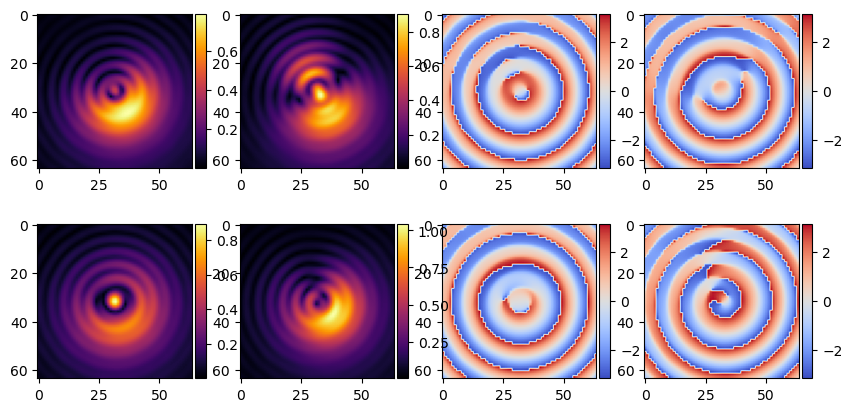

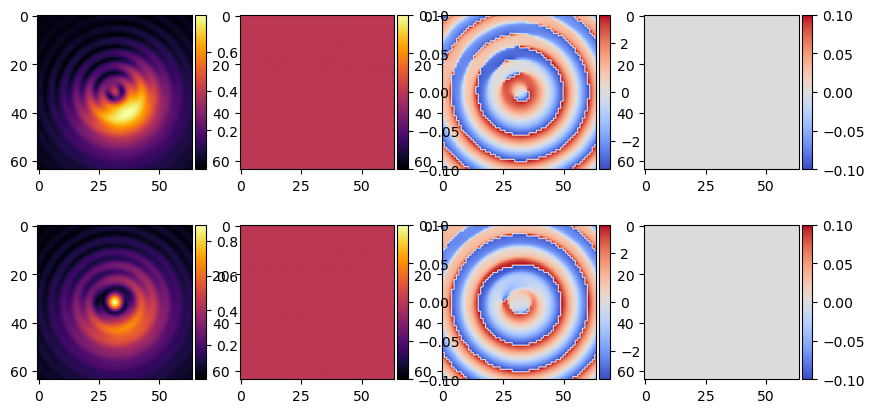

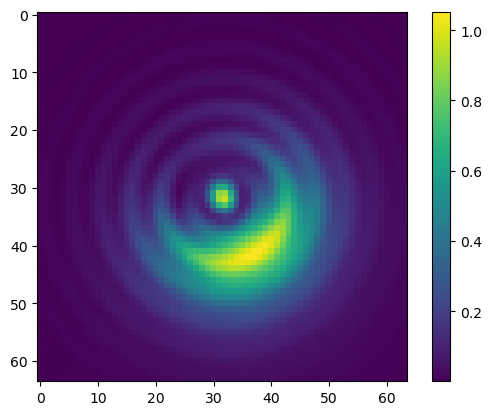

In [96]:
plot_jones(j)
plot_jones(J)
plot_jones(g)
plot_jones(G)
plot_jones(H)
plt.figure()
plt.imshow(I)
plt.colorbar()
plt.show()

In [10]:
def broadcast_transpose(M):
    return np.einsum('...ij->...ji', M)

# The Reverse Model

In [74]:
Ibar = 2 * (I - D)

Hxxbar = 2 * Ibar * Hxx
Hxybar = 2 * Ibar * Hxy
Hyxbar = 2 * Ibar * Hyx
Hyybar = 2 * Ibar * Hyy

# pack into Hbar
Hbar = np.zeros_like(H, dtype=np.complex128)
Hbar[..., 0, 0] = Hxxbar
Hbar[..., 0, 1] = Hxybar
Hbar[..., 1, 0] = Hyxbar
Hbar[..., 1, 1] = Hyybar

#  backpropagate polarizer
Gbar = Hbar @ broadcast_transpose(P).conj()

# backpropagate focus
gbar = focus_fixed_sampling_backprop(
        Gbar,
        input_dx=dx_p,
        prop_dist = efl,
        wavelength=wvl,
        output_dx=img_dx,
        output_samples=A.shape[0],
        shift=(0, 0),
        method='mdft')

# backpropagate retarder
kbar = gbar @ broadcast_transpose(R).conj()

# backpropagate aperture
Jbar = A[..., np.newaxis, np.newaxis].conj() * kbar

# backpropagate focus diversity
jbar = W[..., np.newaxis, np.newaxis].conj() * Jbar

# Retrieve basis coefficients with t e n s o r d o t
abar = np.tensordot(basis, jbar)


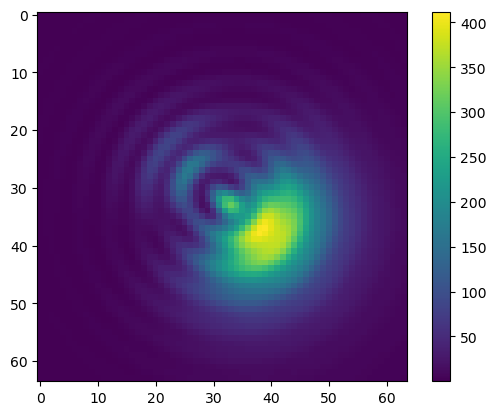

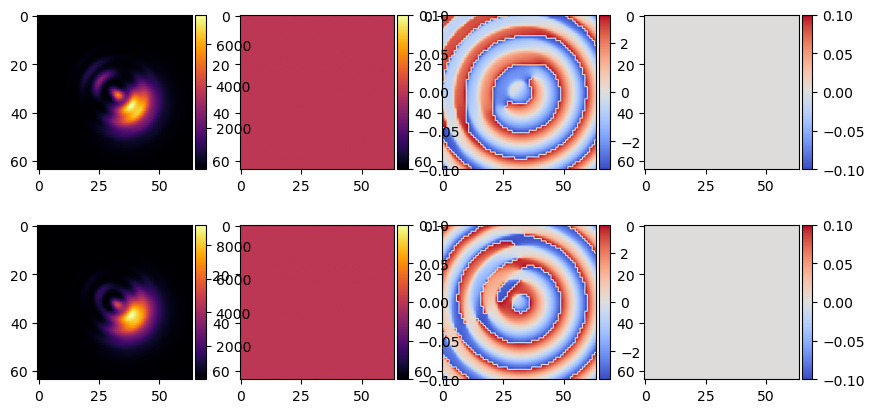

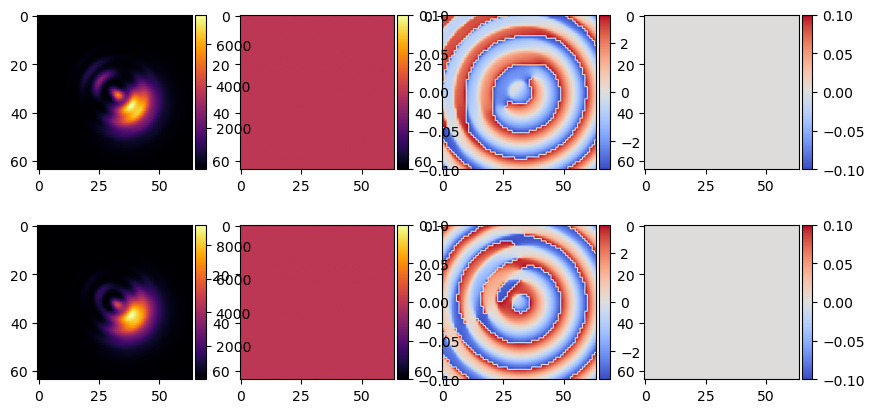

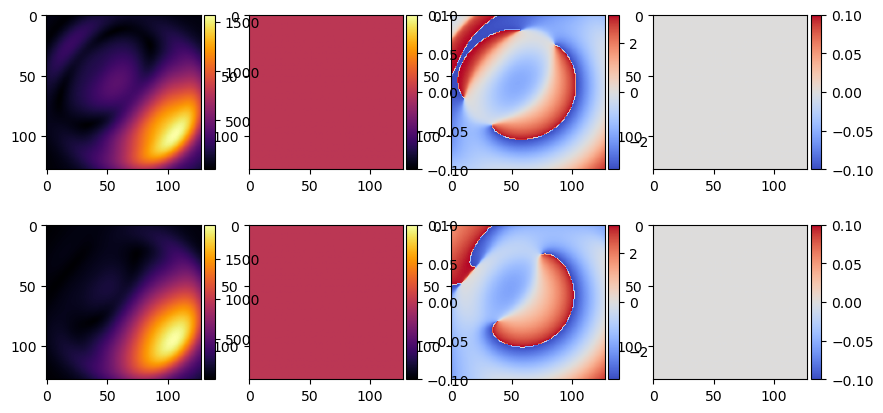

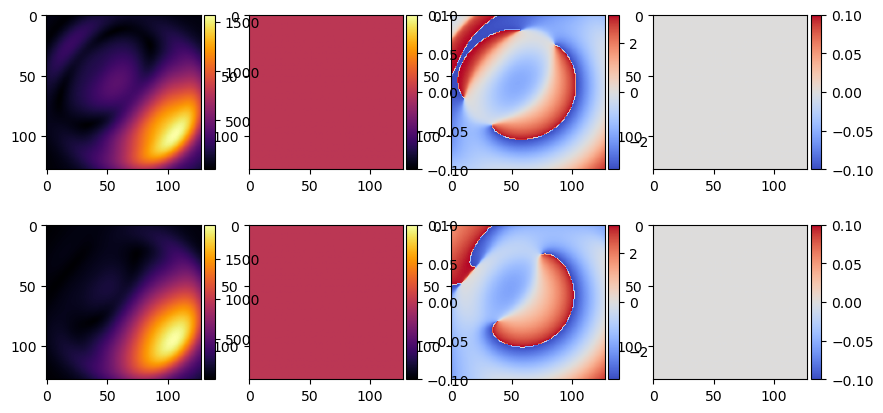

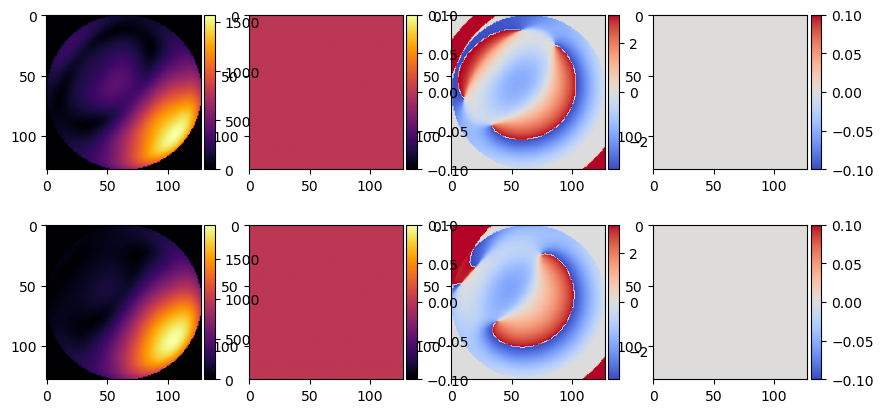

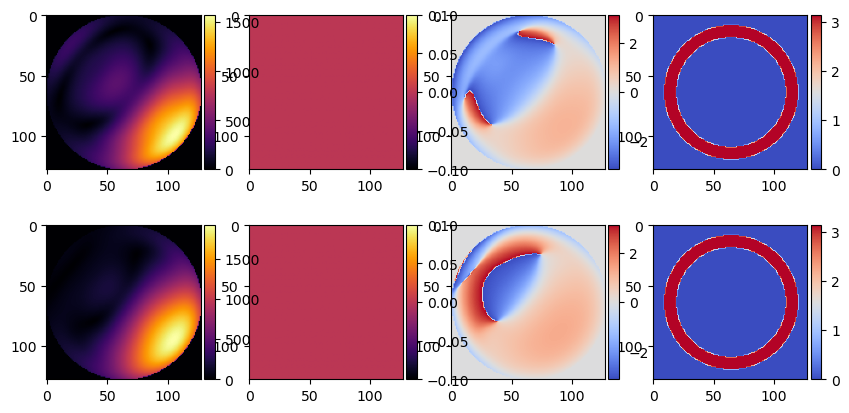

In [102]:
plt.figure()
plt.imshow(Ibar)
plt.colorbar()
plt.show()

plot_jones(Hbar)
plot_jones(Gbar)
plot_jones(gbar)
plot_jones(kbar)
plot_jones(Jbar)
plot_jones(jbar)

In [68]:
class PZPhaseRetireval:
    """Class to perform jones pupil phase retrieval

    the shape of x should be 4 x len(basis), but minimize doesn't like that
    so we will need to reshape

    """
    def __init__(self, amp, amp_dx, efl, wvl, basis, target, img_dx,
                 defocus_waves=0, retarder_angle=0, polarizer_angle=0, initial_phase=None):
        if initial_phase is None:
            jones = np.zeros([*amp.shape,2,2], dtype=float)

        self.amp = amp
        self.amp_select = self.amp > 1e-9
        self.amp_dx = amp_dx
        self.epd = amp.shape[0] * amp_dx
        self.efl = efl
        self.wvl = wvl
        self.basis = basis
        self.img_dx = img_dx
        self.D = target
        self.jones = jones
        self.zonal = False
        self.defocus = defocus_waves
        self.retarder_angle = retarder_angle
        self.polarizer_angle = polarizer_angle
        self.lenbasis = len(self.basis)

        # configure the defocus polynomial
        x, y = make_xy_grid(amp.shape[0], diameter=self.epd)
        r, t = cart_to_polar(x, y)
        r_z = r / (self.epd / 2)
        self.defocus_polynomial = hopkins(0, 2, 0, r_z, t, 0)
        self.defocus_aberration = 2 * np.pi * self.defocus_polynomial * self.defocus * self.amp
        self.cost = []

        # configure polarization diversity
        self.R = quarter_wave_plate(theta=self.retarder_angle, shape=amp.shape)
        self.P = linear_polarizer(theta=self.polarizer_angle, shape=D.shape)

    def set_optimization_method(self, zonal=False):
        self.zonal = zonal

    def update(self, x):

        x = x0.reshape([Npolynomials, 2, 2, 2])
        self.x = x
        a = x[..., 0] + 1j*x[..., 1] # 

        if not self.zonal:
            j = np.tensordot(self.basis, a, axes=(0, 0))

        else:
            j = np.zeros(self.amp.shape, dtype=float)
            j[self.amp_select] = a


        # apply focus diversity
        self.W = np.exp(1j * defocus_aberration)
        self.W = self.W[..., np.newaxis, np.newaxis]
        J = j * self.W

        # apply polarization diversity
        g = J @ self.R

        # to image plane
        G = focus_fixed_sampling(
                g,
                input_dx=self.amp_dx,
                prop_dist = self.efl,
                wavelength=self.wvl,
                output_dx=self.img_dx,
                output_samples=self.D.shape,
                shift=(0, 0),
                method='mdft')

        # Analyze polarization diversity
        H = G @ self.P

        Hxx = H[..., 0, 0]
        Hxy = H[..., 0, 1]
        Hyx = H[..., 1, 0]
        Hyy = H[..., 1, 1]

        # compute intensity
        I = np.abs(Hxx)**2 + np.abs(Hxy)**2 + np.abs(Hyx)**2 + np.abs(Hyy)**2

        # compute error
        E = np.sum(I-D)**2

        self.J = J
        self.j = j
        self.g = g
        self.G = G
        self.H = H
        self.Hxx = Hxx
        self.Hxy = Hxy
        self.Hyx = Hyx
        self.Hyy = Hyy
        self.I = I
        self.E = E
        return
    
    def fwd(self, x):
        self.update(x)
        return self.E
    
    def rev(self, x):
        self.update(x)

        Ibar = 2 * (self.I - self.D)

        Hxxbar = 2 * Ibar * self.Hxx
        Hxybar = 2 * Ibar * self.Hxy
        Hyxbar = 2 * Ibar * self.Hyx
        Hyybar = 2 * Ibar * self.Hyy

        # pack into Hbar
        Hbar = np.zeros_like(self.H, dtype=np.complex128)
        Hbar[..., 0, 0] = Hxxbar
        Hbar[..., 0, 1] = Hxybar
        Hbar[..., 1, 0] = Hyxbar
        Hbar[..., 1, 1] = Hyybar

        #  backpropagate polarizer
        Gbar = Hbar @ broadcast_transpose(self.P).conj()

        # backpropagate focus
        gbar = focus_fixed_sampling_backprop(
                Gbar,
                input_dx=self.amp_dx,
                prop_dist = self.efl,
                wavelength=self.wvl,
                output_dx=self.img_dx,
                output_samples=self.amp.shape[0],
                shift=(0, 0),
                method='mdft')

        # backpropagate retarder
        kbar = gbar @ broadcast_transpose(self.R).conj()

        # backpropagate aperture
        Jbar = self.amp[..., np.newaxis, np.newaxis].conj() * kbar

        # backpropagate focus diversity
        jbar = self.W.conj() * Jbar

        # Retrieve basis coefficients with t e n s o r d o t
        abar = np.tensordot(basis, jbar)
        abar_real = np.real(abar)
        abar_imag = np.imag(abar)

        self.Ibar = Ibar
        self.Hbar = Hbar
        self.Gbar = Gbar
        self.gbar = gbar
        self.kbar = kbar
        self.Jbar = Jbar
        self.jbar = jbar

        if not self.zonal:
            self.abar = np.zeros_like(self.x)
            self.abar[...,0] = abar_real
            self.abar[...,1] = abar_imag
            return self.abar.ravel()
        else:
            return self.jbar[self.amp_select]
        

    def fg(self, x):
        g = self.rev(x)
        f = self.E
        self.cost.append(f)
        return f, g
        

In [69]:
pzpr = PZPhaseRetireval(A, dx_p, efl, wvl, basis, D, img_dx, defocus_waves=1, polarizer_angle=0)

In [89]:
from scipy.optimize import minimize
coeffs_x0 = np.random.random([Npolynomials,2,2,2]) / 100
results = minimize(pzpr.fg,
                   x0=coeffs_x0.ravel(),
                   jac=True, method='L-BFGS-B',
                   options={'maxls': 20, 'disp': 1})

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           40     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.43875D+06    |proj g|=  6.69772D+03


 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   40      1     21      1     0     0   6.698D+03   1.439D+06
  F =   1438746.6278066321     

ABNORMAL_TERMINATION_IN_LNSRCH                              



 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.


In [71]:
pzpr.fg(coeffs_x0.ravel())

(27616377812.792217,
 array([       0.        ,        0.        ,        0.        ,
               0.        ,        0.        ,        0.        ,
               0.        ,        0.        ,  6431263.03994356,
         7104674.49401415,        0.        ,        0.        ,
         8334318.13752462, 13868211.65579632,        0.        ,
               0.        ,  7701165.03657936,  8059690.91544904,
               0.        ,        0.        ,  9090984.86529119,
         9079488.95625486,        0.        ,        0.        ,
         5959348.90523726,  7419469.42958258,        0.        ,
               0.        ,  5912241.85413572,  7677137.69500777,
               0.        ,        0.        ,  5632097.81935647,
         3425081.19213018,        0.        ,        0.        ,
         6766955.19465276,   893534.65368214,        0.        ,
               0.        ]))

(40,)